# CrowdTruth for Sparse Multiple Choice Tasks: Person Annotation in Video

In this tutorial, we will apply CrowdTruth metrics to a **multiple choice** crowdsourcing task for **Person Annotation** from **video fragments**. The workers were asked to watch a video of about 3-5 seconds and then pick from a multiple choice list which are the types of person that appear in the video fragment. The task was executed on [FigureEight](https://www.figure-eight.com/).

This is a screenshot of the task as it appeared to workers:

![Task Template](img/person-video-sparse-multiple-choice.png)

A sample dataset for this task is available in [this file](https://raw.githubusercontent.com/CrowdTruth/CrowdTruth-core/master/tutorial/data/person-video-sparse-multiple-choice.csv), containing raw output from the crowd on FigureEight. Download the file and place it in a folder named `data` that has the same root as this notebook. Now you can check your data:

In [1]:
import pandas as pd

test_data = pd.read_csv("data/person-video-sparse-multiple-choice.csv")
test_data.head()

,_unit_id,_created_at,_id,_started_at,_tainted,_channel,_trust,_worker_id,_country,_region,...,imagetags,keyframeid_gold,selected_answer_gold,selectedtags_desc_gold,selectedtags_manual_gold,selectedtags_subs_gold,selectedtags_tags_gold,subtitles,subtitletags,videolocation
0,1856660165,8/30/2018 09:21:29,4016584997,8/30/2018 09:21:19,False,instagc,1,39127197,GBR,N9,...,industry__c0_###_grinder__c1_###_production__c...,NaN,NaN,NaN,NaN,NaN,NaN,Italian astronaut samantha cristoforetti uploa...,Italian__0_###_astronaut__1_###_samantha__2_##...,https://joran.org/ct/entity.admin.unit.2649/85...
1,1856660165,8/30/2018 11:01:36,4016713176,8/30/2018 11:01:20,False,prodege,1,15965551,GBR,D8,...,industry__c0_###_grinder__c1_###_production__c...,NaN,NaN,NaN,NaN,NaN,NaN,Italian astronaut samantha cristoforetti uploa...,Italian__0_###_astronaut__1_###_samantha__2_##...,https://joran.org/ct/entity.admin.unit.2649/85...
2,1856660165,8/30/2018 11:04:42,4016717961,8/30/2018 11:04:14,False,prodege,1,39740855,CAN,ON,...,industry__c0_###_grinder__c1_###_production__c...,NaN,NaN,NaN,NaN,NaN,NaN,Italian astronaut samantha cristoforetti uploa...,Italian__0_###_astronaut__1_###_samantha__2_##...,https://joran.org/ct/entity.admin.unit.2649/85...
3,1856660165,8/30/2018 11:27:28,4016754957,8/30/2018 11:27:04,False,clixsense,1,6576528,CAN,SK,...,industry__c0_###_grinder__c1_###_production__c...,NaN,NaN,NaN,NaN,NaN,NaN,Italian astronaut samantha cristoforetti uploa...,Italian__0_###_astronaut__1_###_samantha__2_##...,https://joran.org/ct/entity.admin.unit.2649/85...
4,1856660165,8/30/2018 12:10:29,4016825412,8/30/2018 12:10:15,False,prodege,1,3587109,CAN,NS,...,industry__c0_###_grinder__c1_###_production__c...,NaN,NaN,NaN,NaN,NaN,NaN,Italian astronaut samantha cristoforetti uploa...,Italian__0_###_astronaut__1_###_samantha__2_##...,https://joran.org/ct/entity.admin.unit.2649/85...


## Declaring a pre-processing configuration

The pre-processing configuration defines how to interpret the raw crowdsourcing input. To do this, we need to define a configuration class. First, we import the default CrowdTruth configuration class:

In [2]:
import crowdtruth
from crowdtruth.configuration import DefaultConfig

Our test class inherits the default configuration `DefaultConfig`, while also declaring some additional attributes that are specific to the Person Type/Role Annotation in Video task:

* **`inputColumns`:** list of input columns from the .csv file with the input data
* **`outputColumns`:** list of output columns from the .csv file with the answers from the workers
* **`annotation_separator`:** string that separates between the crowd annotations in `outputColumns`
* **`open_ended_task`:** boolean variable defining whether the task is open-ended (i.e. the possible crowd annotations are not known beforehand, like in the case of free text input); in the task that we are processing, workers pick the answers from a pre-defined list, therefore the task is not open ended, and this variable is set to `False`
* **`annotation_vector`:** list of possible crowd answers, mandatory to declare when `open_ended_task` is `False`; for our task, this is the list of relations
* **`processJudgments`:** method that defines processing of the raw crowd data; for this task, we process the crowd answers to correspond to the values in `annotation_vector`

The complete configuration class is declared below:

In [3]:
class TestConfig(DefaultConfig):
    inputColumns = ["videolocation", "subtitles", "imagetags", "subtitletags"]
    outputColumns = ["selectedtags_manual", "selected_tags"]
    
    # processing of a closed task
    open_ended_task = True
    annotation_vector = []
    
    def processJudgments(self, judgments):
        # pre-process output to match the values in annotation_vector
        for col in self.outputColumns:
            # transform to lowercase
            judgments[col] = judgments[col].apply(lambda x: str(x).lower())
            # remove square brackets from annotations
            judgments[col] = judgments[col].apply(lambda x: str(x).replace('[]','no tags'))
            judgments[col] = judgments[col].apply(lambda x: str(x).replace('[',''))
            judgments[col] = judgments[col].apply(lambda x: str(x).replace(']',''))
            # remove the quotes around the annotations
            judgments[col] = judgments[col].apply(lambda x: str(x).replace('"',''))
        return judgments

## Pre-processing the input data

After declaring the configuration of our input file, we are ready to pre-process the crowd data:

In [4]:
data, config = crowdtruth.load(
    file = "data/person-video-sparse-multiple-choice.csv",
    config = TestConfig()
)

data['judgments'].head(10)

/Users/oanainel/Projects/CrowdTruth-core/crowdtruth/load.py:201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  annotations = pd.concat([annotations, res], axis=0)


,output.selected_tags,output.selectedtags_manual,output.selected_tags.count,output.selected_tags.unique,output.selectedtags_manual.count,output.selectedtags_manual.unique,submitted,started,worker,unit,duration,job
judgment,,,,,,,,,,,,
4016584997,"{u'0_###_italian': 1, u'1_###_astronaut': 1, u...",{u'no tags': 1},8,8,1,1,2018-08-30 09:21:29,2018-08-30 09:21:19,39127197,1856660165,10,data/person-video-sparse-multiple-choice
4016713176,{u'1_###_astronaut': 1},{u'no tags': 1},1,1,1,1,2018-08-30 11:01:36,2018-08-30 11:01:20,15965551,1856660165,16,data/person-video-sparse-multiple-choice
4016717961,"{u'0_###_italian': 1, u'1_###_astronaut': 1}",{u'no tags': 1},2,2,1,1,2018-08-30 11:04:42,2018-08-30 11:04:14,39740855,1856660165,28,data/person-video-sparse-multiple-choice
4016754957,"{u'1_###_astronaut': 1, u'2_###_samantha': 1, ...",{u'no tags': 1},7,7,1,1,2018-08-30 11:27:28,2018-08-30 11:27:04,6576528,1856660165,24,data/person-video-sparse-multiple-choice
4016825412,"{u'1_###_astronaut': 1, u'2_###_samantha': 1, ...",{u'no tags': 1},5,5,1,1,2018-08-30 12:10:29,2018-08-30 12:10:15,3587109,1856660165,14,data/person-video-sparse-multiple-choice
4016831835,{u'1_###_astronaut': 1},{u'flag': 1},1,1,1,1,2018-08-30 12:13:53,2018-08-30 12:13:32,28813722,1856660165,21,data/person-video-sparse-multiple-choice
4016865968,{u'1_###_astronaut': 1},{u'no tags': 1},1,1,1,1,2018-08-30 12:32:11,2018-08-30 12:31:55,6377879,1856660165,16,data/person-video-sparse-multiple-choice
4016947003,{u'no tags': 1},{u'fake': 1},1,1,1,1,2018-08-30 13:12:43,2018-08-30 13:11:42,11063039,1856660165,61,data/person-video-sparse-multiple-choice
4016955915,"{u'1_###_astronaut': 1, u'i2_###_technology': 1}",{u'no tags': 1},2,2,1,1,2018-08-30 13:16:32,2018-08-30 13:16:23,40421145,1856660165,9,data/person-video-sparse-multiple-choice


## Computing the CrowdTruth metrics

The pre-processed data can then be used to calculate the CrowdTruth metrics:

In [5]:
results = crowdtruth.run(data, config)

KeyError: 0

`results` is a dict object that contains the quality metrics for the video fragments, annotations and crowd workers.

The **video fragment metrics** are stored in `results["units"]`:

In [42]:
results["units"].head()

,duration,input.imagetags,input.subtitles,input.subtitletags,input.videolocation,job,output.selected_tags,output.selected_tags.annotations,output.selected_tags.unique_annotations,output.selectedtags_manual,output.selectedtags_manual.annotations,output.selectedtags_manual.unique_annotations,worker,uqs,unit_annotation_score,uqs_initial,unit_annotation_score_initial
unit,,,,,,,,,,,,,,,,,
1856660165,31.45,industry__c0_###_grinder__c1_###_production__c...,Italian astronaut samantha cristoforetti uploa...,Italian__0_###_astronaut__1_###_samantha__2_##...,https://joran.org/ct/entity.admin.unit.2649/85...,data/person-video-sparse-multiple-choice,"{u'c3_###_technology': 5, u'i2_###_technology'...",79,14,"{u'woman': 1, u'space': 1, u'male narrator': 1...",22,9,20,0.483332,"{u'c3_###_technology': 0.338443518378, u'i2_##...",0.490724,"{u'c3_###_technology': 0.25, u'i2_###_technolo..."
1856660167,77.20,man__c0_###_soccer__c1_###_portrait__c2_###_pe...,this phenomena is it's massive the,phenomena__0_###_massive__1_###_,https://joran.org/ct/entity.admin.unit.2649/85...,data/person-video-sparse-multiple-choice,"{u'i3_###_person': 11, u'i2_###_portrait': 1, ...",74,12,"{u'explorer': 3, u'science': 1, u'forhead': 1,...",23,7,20,0.695091,"{u'i3_###_person': 0.673788005949, u'i2_###_po...",0.454332,"{u'i3_###_person': 0.55, u'i2_###_portrait': 0..."
1856660168,39.05,people__c0_###_man__c1_###_adult__c2_###_portr...,around could the lights be coming from,lights__0_###_coming__1_###_,https://joran.org/ct/entity.admin.unit.2649/85...,data/person-video-sparse-multiple-choice,"{u'0_###_lights': 5, u'c3_###_portrait': 1, u'...",89,11,"{u'sci': 1, u'move': 1, u'hands': 1, u'smile':...",22,6,20,0.750240,"{u'0_###_lights': 0.0170258198493, u'c3_###_po...",0.507578,"{u'0_###_lights': 0.25, u'c3_###_portrait': 0...."
1856660169,52.40,water__c0_###_no person__c1_###_ocean__c2_###_...,when investigators map the coordinates onto lo...,investigators__0_###_map__1_###_coordinates__2...,https://joran.org/ct/entity.admin.unit.2649/85...,data/person-video-sparse-multiple-choice,"{u'c4_###_sea': 4, u'5_###_lights': 4, u'8_###...",72,16,"{u'pattern': 1, u'no tags': 19}",20,2,20,0.560891,"{u'c4_###_sea': 0.120931539941, u'5_###_lights...",0.315906,"{u'c4_###_sea': 0.2, u'5_###_lights': 0.2, u'8..."
1856660170,34.70,sky__c0_###_no person__c1_###_power__c2_###_el...,the bright lights are part of a,bright lights__0_###_,https://joran.org/ct/entity.admin.unit.2649/85...,data/person-video-sparse-multiple-choice,"{u'c0_###_sky': 3, u'i0_###_wire': 4, u'i3_###...",50,11,"{u'industry': 1, u'ocean': 1, u'boat': 2, u'fi...",25,7,20,0.903624,"{u'c0_###_sky': 0.0332782097387, u'i0_###_wire...",0.397324,"{u'c0_###_sky': 0.15, u'i0_###_wire': 0.2, u'i..."


The `uqs` column in `results["units"]` contains the **video fragment quality scores**, capturing the overall workers agreement over each video fragment. Here we plot its histogram:

Text(0,0.5,u'Video Fragment')

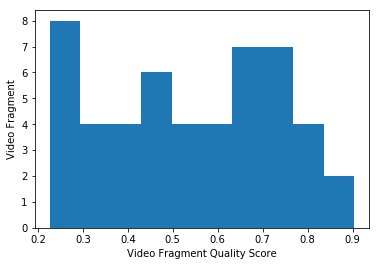

In [43]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(results["units"]["uqs"])
plt.xlabel("Video Fragment Quality Score")
plt.ylabel("Video Fragment")

The `unit_annotation_score` column in `results["units"]` contains the **video fragment-annotation scores**, capturing the likelihood that an annotation is expressed in a video fragment. For each video fragment, we store a dictionary mapping each annotation to its video fragment-relation score.

In [45]:
results["units"]["unit_annotation_score_initial"].head()

unit
1856660165    {u'c3_###_technology': 0.25, u'i2_###_technolo...
1856660167    {u'i3_###_person': 0.55, u'i2_###_portrait': 0...
1856660168    {u'0_###_lights': 0.25, u'c3_###_portrait': 0....
1856660169    {u'c4_###_sea': 0.2, u'5_###_lights': 0.2, u'8...
1856660170    {u'c0_###_sky': 0.15, u'i0_###_wire': 0.2, u'i...
Name: unit_annotation_score_initial, dtype: object

The **worker metrics** are stored in `results["workers"]`:

In [46]:
results["workers"].head()

,duration,job,judgment,unit,wqs,wwa,wsa,wqs_initial,wwa_initial,wsa_initial
worker,,,,,,,,,,
1855113,43.60,1,25,25,0.636597,0.734697,0.866475,0.324769,0.474289,0.684750
3587109,15.40,1,25,25,0.411768,0.581163,0.708524,0.366236,0.499577,0.733092
4316379,36.76,1,25,25,0.446025,0.638058,0.699036,0.191752,0.370894,0.516999
6339764,79.28,1,25,25,0.176038,0.423132,0.416035,0.231437,0.387467,0.597309
6367365,53.08,1,25,25,0.508121,0.668064,0.760587,0.280973,0.436799,0.643254


The `wqs` columns in `results["workers"]` contains the **worker quality scores**, capturing the overall agreement between one worker and all the other workers.

Text(0,0.5,u'Workers')

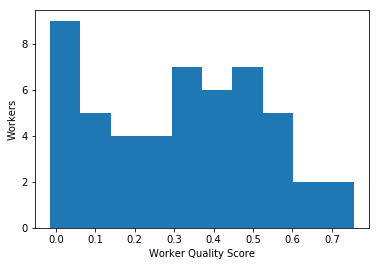

In [47]:
plt.hist(results["workers"]["wqs"])
plt.xlabel("Worker Quality Score")
plt.ylabel("Workers")

The **annotation metrics** are stored in `results["annotations"]`. The `aqs` column contains the **annotation quality scores**, capturing the overall worker agreement over one relation.

In [14]:
results["annotations"]

,output.selected_answer,aqs,aqs_initial
archeologist,1000,1.000000e-08,1.000000e-08
architect,1000,1.000000e-08,1.000000e-08
artist,1000,2.512851e-01,2.520942e-01
astronaut,1000,9.999680e-01,9.523810e-01
athlete,1000,2.801650e-01,2.788104e-01
businessperson,1000,6.188727e-02,9.618163e-02
celebrity,1000,7.459197e-01,6.066316e-01
chef,1000,1.000000e-08,1.000000e-08
criminal,1000,1.272384e-01,1.530612e-01
engineer,1000,3.608684e-02,2.991453e-02
